In [2]:
import biographs as bg

In [3]:
pip install biographs wget

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pydssp

Note: you may need to restart the kernel to use updated packages.


In [5]:
import wget
import os
#download an example pdb file
url = 'https://files.rcsb.org/download/1EEI.pdb'
filename = wget.download(url)


1eei (2).pdb


In [26]:
import pandas as pd
aaproperties = pd.read_csv('./aaindex1.csv', header=0)
print(aaproperties.head())

      A     R     N     D     C     Q     E     G     H     I  ...     M  \
0  4.35  4.38  4.75  4.76  4.65  4.37  4.29  3.97  4.63  3.95  ...  4.52   
1  0.61  0.60  0.06  0.46  1.07  0.00  0.47  0.07  0.61  2.22  ...  1.18   
2  1.18  0.20  0.23  0.05  1.89  0.72  0.11  0.49  0.31  1.45  ...  2.67   
3  1.56  0.45  0.27  0.14  1.23  0.51  0.23  0.62  0.29  1.67  ...  2.96   
4  1.00  0.52  0.35  0.44  0.06  0.44  0.73  0.35  0.60  0.73  ...  1.00   

      F     P     S     T     W     Y     V  \
0  4.66  4.44  4.50  4.35  4.70  4.60  3.95   
1  2.02  1.95  0.05  0.05  2.65  1.88  1.32   
2  1.96  0.76  0.97  0.84  0.77  0.39  1.08   
3  2.03  0.76  0.81  0.91  1.08  0.68  1.14   
4  0.60  0.06  0.35  0.44  0.73  0.44  0.82   

                                         description  \
0   alpha-CH chemical shifts (Andersen et al., 1992)   
1          Hydrophobicity index (Argos et al., 1982)   
2  Signal sequence helical potential (Argos et al...   
3  Membrane-buried preference parame

In [30]:
from Bio import PDB
import warnings
from matplotlib import pyplot as plt
import numpy as np
import torch
import pydssp
from Bio.PDB import PDBParser   
import numpy as np
filename = './1eei.pdb'
    
def read_pdb(filename):
    #silence all warnings
    warnings.filterwarnings('ignore')

    with warnings.catch_warnings():        
        parser = PDB.PDBParser()
        structure = parser.get_structure(filename, filename)
        chains = [ c for c in structure.get_chains()]
        return chains

#return the phi, psi, and omega angles for each residue in a chain
def get_angles(chain):

    phi_psi_angles = []

    chain = [ r for r in chain if PDB.is_aa(r)]
    #sliding window of 3 residues
    polypeptides = [ chain[i:i+3] for i in range(len(chain)) if len(chain[i:i+4]) >= 3]
    #translate to single letter code
    print(polypeptides)


    for poly_index, poly in enumerate(polypeptides):
        phi = None
        psi = None

        if len(poly) >= 3:
            c_minus_1 = poly[len(poly) - 3]["C"].get_vector()
            n = poly[len(poly) - 2]["N"].get_vector()
            ca = poly[len(poly) - 2]["CA"].get_vector()
            c = poly[len(poly) - 2]["C"].get_vector()

            # Calculate phi angle
            phi = PDB.calc_dihedral(c_minus_1, n, ca, c)
            n = poly[len(poly) - 2]["N"].get_vector()
            ca = poly[len(poly) - 2]["CA"].get_vector()
            c = poly[len(poly) - 2]["C"].get_vector()
            n_plus_1 = poly[len(poly) - 1]["N"].get_vector()

            # Calculate psi angle
            psi = PDB.calc_dihedral(n, ca, c, n_plus_1)
        residue = poly[0]
        residue_id = residue.get_full_id()

        phi_psi_angles.append({
            "Chain": residue_id[2],
            "Residue_Number": residue_id[3][1],
            "Residue_Name": residue.get_resname(),
            #translate 3 letter to 1 letter code
            "single_letter_code": PDB.Polypeptide.three_to_one(residue.get_resname()),
            "Phi_Angle": phi,
            "Psi_Angle": psi
        })
    #transform phi and psi angles into a dataframe
    phi_psi_angles = pd.DataFrame(phi_psi_angles)
    #transform the residue names into single letter code
    return phi_psi_angles    

def get_contact_points(chain, distance):
    contact_mat = np.zeros((len(chain), len(chain)))
    for i,r1 in enumerate(chain):
        for j,r2 in enumerate(chain):
            if i< j:
                if 'CA' in r1 and 'CA' in r2:
                    if r1['CA'] - r2['CA'] < distance:
                        contact_mat[i,j] =  r1['CA'] - r2['CA']
    contact_mat = contact_mat + contact_mat.T
    return contact_mat



# Sample coordinates
batch, length, atoms, xyz = 10, 100, 4, 3
## atoms should be 4 (N, CA, C, O) or 5 (N, CA, C, O, H)
typeindex = {'N':0, 'CA':1, 'C':2, 'O':3, 'H':4}

def ret_hbonds(chain):
    #loop through all atoms in a structure
    struct = PDBParser().get_structure('1eei', filename)

    #get the number of atoms in the chain
    #create a numpy array of zeros with the shape of (1, length, atoms, xyz)
    output = np.zeros((1, len(chain), len(typeindex), 3 ))
    for c, res in enumerate(chain):
        atoms = res.get_atoms()
        for at,atom in enumerate(atoms):
            if atom.get_name() in typeindex:
                output[ 0, c ,  typeindex[atom.get_name()] , : ]  = atom.get_coord()
    output = torch.tensor(output)
    print(output.shape)
    mat =  pydssp.get_hbond_map(output[0])
    return mat


#add the amino acid properties to the angles dataframe

def add_aaproperties(angles, aaproperties):
    angles = angles.merge(aaproperties, left_on='single_letter_code', right_index=True, how='left')
    angles = angles.dropna()
    return angles



torch.Size([1, 181, 5, 3])


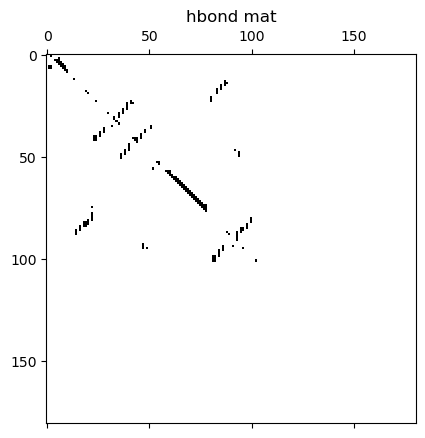

[[<Residue THR het=  resseq=1 icode= >, <Residue PRO het=  resseq=2 icode= >, <Residue GLN het=  resseq=3 icode= >], [<Residue PRO het=  resseq=2 icode= >, <Residue GLN het=  resseq=3 icode= >, <Residue ASN het=  resseq=4 icode= >], [<Residue GLN het=  resseq=3 icode= >, <Residue ASN het=  resseq=4 icode= >, <Residue ILE het=  resseq=5 icode= >], [<Residue ASN het=  resseq=4 icode= >, <Residue ILE het=  resseq=5 icode= >, <Residue THR het=  resseq=6 icode= >], [<Residue ILE het=  resseq=5 icode= >, <Residue THR het=  resseq=6 icode= >, <Residue ASP het=  resseq=7 icode= >], [<Residue THR het=  resseq=6 icode= >, <Residue ASP het=  resseq=7 icode= >, <Residue LEU het=  resseq=8 icode= >], [<Residue ASP het=  resseq=7 icode= >, <Residue LEU het=  resseq=8 icode= >, <Residue CYS het=  resseq=9 icode= >], [<Residue LEU het=  resseq=8 icode= >, <Residue CYS het=  resseq=9 icode= >, <Residue ALA het=  resseq=10 icode= >], [<Residue CYS het=  resseq=9 icode= >, <Residue ALA het=  resseq=10 ic

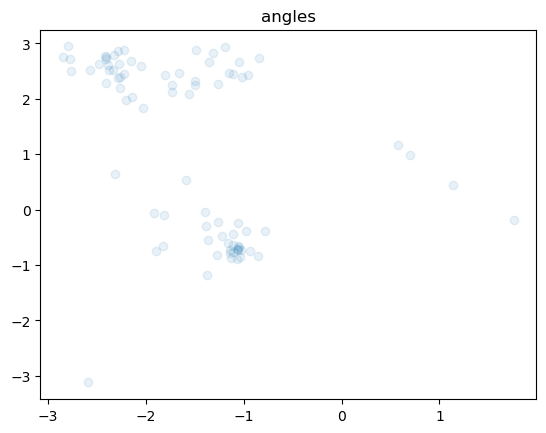

[[0.         3.81947351 6.51483917 ... 0.         0.         0.        ]
 [3.81947351 0.         3.78615642 ... 0.         0.         0.        ]
 [6.51483917 3.78615642 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


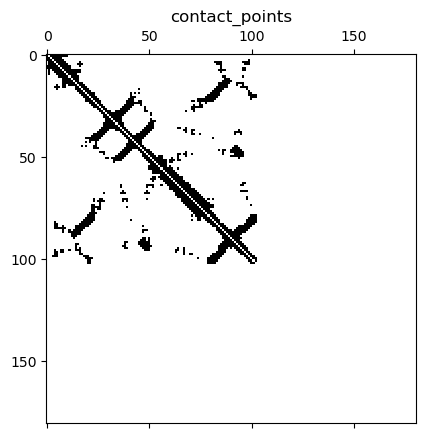

In [31]:
chains = read_pdb(filename)
#test functions
hbond_mat = ret_hbonds(chains[0])
plt.title('hbond mat')
plt.spy(hbond_mat)
plt.show()
angles = get_angles(chains[0])
angles = add_aaproperties(angles, aaproperties.T)
print(angles)
plt.title('angles')
plt.scatter(angles.Phi_Angle , angles.Psi_Angle , alpha=0.1)
plt.show()
contact_points = get_contact_points(chains[0], 10)
print(contact_points)
plt.title('contact_points')
plt.spy(contact_points)
plt.show()
#add a backbone matrix to the graph
backbone = np.zeros((len(chains[0]), len(chains[0])))
np.fill_diagonal(backbone, 1)



In [38]:
adjacency_tensor = np.stack([backbone, contact_points, hbond_mat], axis=0)
print( adjacency_tensor.shape)

(3, 181, 181)


MultiGraph with 181 nodes and 8062 edges


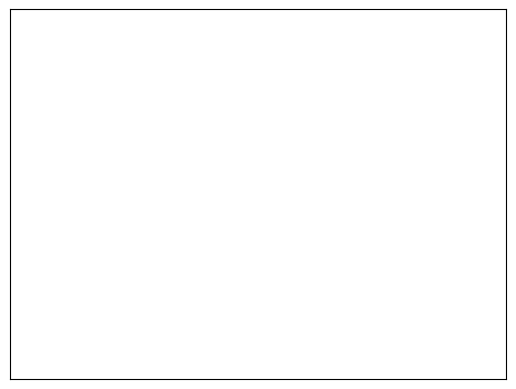

In [49]:
import networkx as nx
#transform the contact matrices into a networkx multigraph 
import colour 

def tensor_to_multigraph(adjacency_tensor):
    # Initialize a MultiGraph
    G = nx.MultiGraph()
    num_nodes = adjacency_tensor.shape[1]
    G.add_nodes_from(range(num_nodes))
    colors = [ c.hex_l for c in  colour.Color('red').range_to(colour.Color('green'), adjacency_tensor.shape[0]) ]
    # Iterate through the adjacency matrices in the tensor
    for i, adj_matrix in enumerate(adjacency_tensor):
        # Add nodes to the MultiGraph
        # Iterate through the rows and columns of the adjacency matrix to add edges
        for row in range(num_nodes):
            for col in range(num_nodes):
                if adjacency_tensor[i,row, col] != 0:
                    # Add an edge with weight (if needed) to the MultiGraph
                    G.add_edge(row, col, weight=adjacency_tensor[i,row, col] , color = colors[i],  layer= i )
    return G

def draw_graph(G , adjacency_tensor ):
    # Get the color of each edge
    edge_colors = [e[2]['color'] for e in G.edges(data=True)]
    # Get the weight of each edge
    edge_weights = [e[2]['weight'] for e in G.edges(data=True)]

    # Get the positions of each node in the graph
    pos = nx.spring_layout(G)
    # Draw the nodes

    
    nx.draw_networkx_nodes(G, pos, node_color='black', node_size=100)
    # Draw the edges

    for i range(0, adjacency_tensor.shape[0]):
        # Draw the edges with a curved arc

        nx.draw_networkx_edges( G, pos, width=edge_weights, edge_color=edge_colors, edgelist=[e for e in G.edges(data=True) if e[2]['layer'] == layer], connectionstyle='arc3, rad = 0.1')
    

    plt.show()
G = tensor_to_multigraph(adjacency_tensor)
print(G)
draw_graph(G, adjacency_tensor=adjacency_tensor)


In [ ]:
! pip install "torch-cluster" "pytorch-lightning>=1.4, <2.0.0" "torch-geometric" "torch-spline-conv" "lightning>=2.0.0rc0" "torch>=1.8.1, <1.14.0" "torch-sparse" "torch-scatter" "torchmetrics>=0.7, <0.12" 

In [ ]:
# Standard libraries
import os

# For downloading pre-trained models
import urllib.request
from urllib.error import HTTPError

# PyTorch Lightning
import lightning as L

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric
import torch_geometric
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn

# PL callbacks
from lightning.pytorch.callbacks import ModelCheckpoint
from torch import Tensor

AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/GNNs/")

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, c_in, c_hidden, c_out, num_layers=2, dp_rate=0.1):
        """
        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of hidden layers
            dp_rate: Dropout rate to apply throughout the network
        """
        super().__init__()
        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers - 1):
            layers += [nn.Linear(in_channels, out_channels), nn.ReLU(inplace=True), nn.Dropout(dp_rate)]
            in_channels = c_hidden
        layers += [nn.Linear(in_channels, c_out)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x, *args, **kwargs):
        """
        Args:
            x: Input features per node
        """
        return self.layers(x)

In [ ]:
class NodeLevelGNN(L.LightningModule):
    def __init__(self, model_name, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        if model_name == "MLP":
            self.model = MLPModel(**model_kwargs)
        else:
            self.model = GNNModel(**model_kwargs)
        self.loss_module = nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index = data.x, data.edge_index
        x = self.model(x, edge_index)

        # Only calculate the loss on the nodes corresponding to the mask
        if mode == "train":
            mask = data.train_mask
        elif mode == "val":
            mask = data.val_mask
        elif mode == "test":
            mask = data.test_mask
        else:
            assert False, "Unknown forward mode: %s" % mode

        loss = self.loss_module(x[mask], data.y[mask])
        acc = (x[mask].argmax(dim=-1) == data.y[mask]).sum().float() / mask.sum()
        return loss, acc

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.1, weight_decay=2e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="val")
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="test")
        self.log("test_acc", acc)
    

In [ ]:
def train_node_classifier(model_name, dataset, **model_kwargs):
    L.seed_everything(42)


    node_data_loader = geom_data.DataLoader(dataset, batch_size=1)

    # Create a PyTorch Lightning trainer
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = L.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
        accelerator="auto",
        devices=AVAIL_GPUS,
        max_epochs=200,
        enable_progress_bar=False,
    )  # 0 because epoch size is 1
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need



    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "NodeLevel%s.ckpt" % model_name)
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = NodeLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        L.seed_everything()
        model = NodeLevelGNN(
            model_name=model_name, c_in=dataset.num_node_features, c_out=dataset.num_classes, **model_kwargs
        )
        trainer.fit(model, node_data_loader, node_data_loader)
        model = NodeLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on the test set
    test_result = trainer.test(model, dataloaders=node_data_loader, verbose=False)
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    _, train_acc = model.forward(batch, mode="train")
    _, val_acc = model.forward(batch, mode="val")
    result = {"train": train_acc, "val": val_acc, "test": test_result[0]["test_acc"]}
    return model, result

In [ ]:


import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv , SAGEConv , TransformerConv, GATConv
from torch import ModuleDict



#import lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
#geometric lightning
from torch_geometric.data import DataLoader


from torch_geometric.data import Data


# Define autoencoder model
class Autoencoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, encoder_layers, decoder_layers):
        super(Autoencoder, self).__init__()


        #adaptive pooling of neighbors

        pooling = 'adaptive_avg_pool1d'

        #module dictionary
        self.encoder = ModuleDict()
        self.decoder = ModuleDict()
        
        
        
        #make hourglass
        encoder_layers = 3
        decoder_layers = 3

        delta_encoder = int((in_channels - hidden_channels) / encoder_layers)
        delta_decoder = int((hidden_channels - in_channels) / decoder_layers)

        hidden_channels_encoder = []
        hidden_channels_decoder = []
        
        
        
        for l in range(encoder_layers) :
            if l == 0 :
                hidden_channels_encoder.append(in_channels)
            else :
                hidden_channels_encoder.append(int(l*delta))
        
        for l in range(decoder_layers) :
            if l == 0 :
                hidden_channels_encoder.append(in_channels)
            else :
                hidden_channels_encoder.append(int(l*delta))
        


        self.encoder = GCNConv(in_channels, hidden_channels)
        self.decoder = GCNConv(hidden_channels, in_channels)

    def forward(self, x, edge_index):
        z = F.relu(self.encoder(x, edge_index))
        x_hat = self.decoder(z, edge_index)
        return z, x_hat

# Instantiate model and optimizer
model = Autoencoder(dataset.num_node_features, 16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    z, x_hat = model(dataset.x, dataset.edge_index)
    loss = F.mse_loss(x_hat, dataset.x)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print('Epoch: {:03d}, Loss: {:.4f}'.format(epoch, loss.item()))

# Extract node embeddings
model.eval()
with torch.no_grad():
    z, _ = model(dataset.x, dataset.edge_index)
node_embeddings = z.detach().cpu().numpy()

print('Node embeddings shape:', node_embeddings.shape)


